# ⚾ Home Run Prediction

The goal of this project is to estimate the probability that a batter will hit a home run during a given plate appearance in the 2025 Major League Baseball (MLB) season (through June 9th). Using a Bayesian hierarchical model, I incorporate both batter-specific and pitcher-specific effects to account for variation in home run likelihood across different matchups. This approach enables partial pooling, providing robust inference even for players with limited data.

This notebook serves as an initial foundation. Future iterations will incorporate additional variables related to batting, pitching, and environmental conditions (such as ballpark characteristics and weather).


In [1]:
# # Import libraries
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd

# Mount Google Drive to access files stored in Drive from Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading in Data

In [2]:
# Load the at-bats dataset from Google Drive
at_bats_2025 = pd.read_csv("/content/drive/MyDrive/Homerun Prediction Model/data/at_bats_2025.csv")
at_bats_2025.head()

,game_date,pitcher_name,home_team,away_team,inning,inning_topbot,at_bat_number,batter_name,pitch_number,outs_when_up,p_throws,events,description,starting_pitcher,home_run
0,2025-03-22,"Abbott, Andrew",SD,CIN,1,Bot,4,Fernando Tatís,1,0,L,field_out,hit_into_play,1,0
1,2025-03-22,"Abbott, Andrew",SD,CIN,1,Bot,5,Luis Arráez,4,1,L,field_out,hit_into_play,1,0
2,2025-03-22,"Abbott, Andrew",SD,CIN,1,Bot,6,Manny Machado,3,2,L,single,hit_into_play,1,0
3,2025-03-22,"Abbott, Andrew",SD,CIN,1,Bot,7,Jackson Merrill,6,2,L,strikeout,swinging_strike,1,0
4,2025-03-22,"Abbott, Andrew",SD,CIN,2,Bot,11,Xander Bogaerts,5,0,L,field_out,hit_into_play,1,0


In [3]:
# Examine shape of the at-bats dataset
at_bats_2025.shape

(80359, 15)

## Home Run Rate

The code below calculates the empirical home run rate from the dataset by dividing the total number of home runs by the total number of plate appearances (at-bats). This provides a baseline estimate of how frequently home runs occur in the dataset and informs the selection of prior distributions for the model's parameters.


In [4]:
# Total number of at-bats
total_at_bats = len(at_bats_2025)

# Total number of home runs
total_home_runs = at_bats_2025["home_run"].sum()

# Empirical home run rate
hr_rate = total_home_runs / total_at_bats

print(f"Home Run Rate: {hr_rate:.4f} ({hr_rate*100:.2f}%)")

Home Run Rate: 0.0288 (2.88%)


## Bayesian Home Run Model with Partial Pooling

To start, I construct a Bayesian model to estimate the probability that a given batter hits a home run against a given pitcher. I model each plate appearance (at-bat) as a separate Bernoulli trial, allowing for fine-grained modeling of individual outcomes and capturing variation across both batters and pitchers.

Home run outcomes are influenced by both the batter's offensive power and the pitcher's ability to suppress power. We model the probability of a home run during an individual plate appearance between batter $i$ and pitcher $j$ as:

$ $

$$
\theta_{ij} = \frac{\alpha_i}{\alpha_i + \beta_j}
$$

$ $

(where this expression mirrors the [Expectation of the Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)
with parameters $\alpha_i$ and $\beta_j$)


where:

- $\alpha_i$ is a latent, non-negative parameter representing batter $i$'s propensity to hit home runs  
- $\beta_j$ is a latent, non-negative parameter representing pitcher $j$'s ability to suppress home runs

The outcome is whether or not the batter hits a home run, modeled as:

$ $

$$
y_{ij} \sim \text{Bernoulli}(\theta_{ij})
$$



### Hierarchical Modeling and Partial Pooling

I place Half-Normal priors on the batter-specific $\alpha_i$ and pitcher-specific $\beta_j$ parameters:

$ $

$$
\alpha_i \sim \text{HalfNormal}(\sigma = 0.03) \\
\beta_j \sim \text{HalfNormal}(\sigma = 1)
$$

$ $

These priors are fixed to reflect observed data characteristics:

- A typical home run rate of 2.88% motivates setting $\sigma = 0.03$ for batters, since the expected value of $\frac{\alpha_i}{\alpha_i + \beta_j}$ should roughly match this proportion
- A broader prior on pitchers ($\sigma = 1$) allows more flexibility in modeling suppression ability across the population

This setup encourages realistic prior predictions while enabling **partial pooling**:

- Players with limited data shrink toward the population average
- More observed data allows the model to learn individualized strengths or weaknesses
- The Half-Normal constraint keeps all parameters non-negative, consistent with their interpretation as rate-like quantities

By fixing the hyperparameters, we gain control over prior influence and ensure alignment with empirical data patterns.


### Posterior Sampling Configuration

The sampling configuration uses 2,000 posterior draws, 1,000 tuning steps, and a target acceptance probability of 0.9, which [reduces the likelihood of divergent transitions and improves stability](https://discourse.pymc.io/t/there-were-12-divergences-after-tuning-increase-target-accept-or-reparameterize/7945).


**Note:** The `pm.sample` line is commented out because the resulting diagnostic plots may not render properly when viewing the notebook on GitHub.

In [5]:
# Assign integer indices to each unique batter and pitcher
at_bats_2025["batter_idx"] = at_bats_2025["batter_name"].astype("category").cat.codes
at_bats_2025["pitcher_idx"] = at_bats_2025["pitcher_name"].astype("category").cat.codes

# Count total number of unique batters and pitchers
num_batters = at_bats_2025["batter_idx"].nunique()
num_pitchers = at_bats_2025["pitcher_idx"].nunique()

In [13]:
with pm.Model() as model:
    # Hyperpriors on the scale of batter and pitcher effects
    mu_alpha = pm.HalfNormal("mu_alpha", sigma=0.03)
    mu_beta = pm.HalfNormal("mu_beta", sigma=1)

    # Batter-specific latent parameters (HR ability)
    alpha = pm.HalfNormal("alpha", sigma=mu_alpha, shape=num_batters)

    # Pitcher-specific latent parameters (HR suppression ability)
    beta = pm.HalfNormal("beta", sigma=mu_beta, shape=num_pitchers)

    # Home run probability using a Beta-mean-like functional form
    theta = alpha[at_bats_2025["batter_idx"].values] / (
        alpha[at_bats_2025["batter_idx"].values] + beta[at_bats_2025["pitcher_idx"].values]
    )

    # Bernoulli likelihood for observed home run outcomes
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=at_bats_2025["home_run"].values)

    # Draw posterior samples
    #trace = pm.sample(2000, tune=1000, target_accept=0.9, chains=4, random_seed=42)

## Evaluation

In [7]:
# Display summary statistics for selected model parameters
az.summary(trace, var_names=["mu_alpha", "mu_beta", "alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,0.024,0.009,0.005,0.039,0.003,0.001,8.0,13.0,1.44
mu_beta,1.205,0.477,0.227,1.971,0.164,0.076,8.0,13.0,1.44
alpha[0],0.052,0.023,0.010,0.092,0.007,0.003,9.0,13.0,1.35
alpha[1],0.010,0.011,0.000,0.029,0.001,0.001,48.0,258.0,1.05
alpha[2],0.026,0.015,0.003,0.052,0.004,0.001,14.0,28.0,1.20
...,...,...,...,...,...,...,...,...,...
beta[914],1.103,0.891,0.031,2.693,0.145,0.057,28.0,190.0,1.09
beta[915],1.152,0.891,0.035,2.764,0.155,0.056,25.0,91.0,1.10
beta[916],1.093,0.869,0.017,2.636,0.148,0.053,26.0,128.0,1.09
beta[917],1.179,0.892,0.037,2.788,0.160,0.054,24.0,79.0,1.10


array([[<Axes: title={'center': 'mu_alpha'}>,
        <Axes: title={'center': 'mu_alpha'}>],
       [<Axes: title={'center': 'mu_beta'}>,
        <Axes: title={'center': 'mu_beta'}>]], dtype=object)

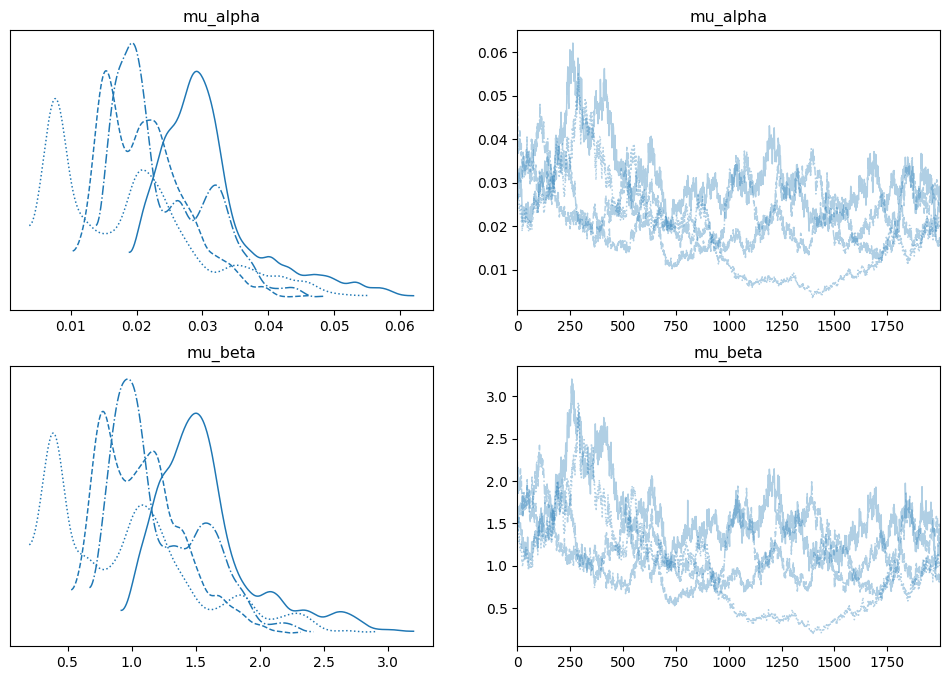

In [8]:
# Plot the trace and posterior density for the hyperparameters mu_alpha and mu_beta
az.plot_trace(trace, var_names=["mu_alpha", "mu_beta"], figsize=(12, 8), compact=True)

# TODO

- Analyze Posterior Density Plots and Trace Plots

## Prediction

On June 10th, Aaron Judge hit a homerun against Kansas City Royals pitcher Noah Cameron. Below, I will estimate the probability that Aaron Judge will hit a homerun against this pitcher as an informal test of the models' performacne.

In [9]:
# Get batter index for Aaron Judge
judge_idx = at_bats_2025[at_bats_2025["batter_name"] == "Aaron Judge"]["batter_idx"].iloc[0]

# Get pitcher index for Cameron, Noah (adjusted to match name format in data)
cameron_idx = at_bats_2025[at_bats_2025["pitcher_name"] == "Cameron, Noah"]["pitcher_idx"].iloc[0]

In [10]:
# Extract posterior samples of α (Judge) and β (Cameron)
alpha_samples = trace.posterior["alpha"].values[:, :, judge_idx].flatten()
beta_samples = trace.posterior["beta"].values[:, :, cameron_idx].flatten()

In [11]:
# Compute posterior samples of θ_ij = α_i / (α_i + β_j)
theta_samples = alpha_samples / (alpha_samples + beta_samples)

In [12]:
# Calculate summary statistics
mean_prob = np.mean(theta_samples)
cred_interval = np.percentile(theta_samples, [2.5, 97.5])

# Print predicted probability and 95% credible interval for a single at-bat
print(f"Estimated HR probability for a given at-bat (Aaron Judge vs Cameron, Noah): {mean_prob:.4f}")
print(f"95% credible interval: [{cred_interval[0]:.4f}, {cred_interval[1]:.4f}]")


Estimated HR probability for a given at-bat (Aaron Judge vs Cameron, Noah): 0.0486
95% credible interval: [0.0174, 0.1105]


## TODO

- Add in analysis